In [2]:
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm

plt.rcParams.update({
    'font.size': 11,       # Default text size
    'axes.titlesize': 10,  # Title size
    'axes.labelsize': 10,  # Axis label size
    'xtick.labelsize': 8, # X-tick label size
    'ytick.labelsize': 8, # Y-tick label size
    'legend.fontsize': 8, # Legend font size
    'figure.titlesize': 10 # Figure title size
})

In [3]:
# Load data
path = [
    r'/nird/projects/NS9608K/MSc_EK/Data/model_69_section.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/model_70_section.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/model_71_section.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/model_72_section.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/model_735_section.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/model_75_section.nc'

]
model_data = [xr.open_dataset(x) for x in path]

path = [
    r'/nird/projects/NS9608K/MSc_EK/Data/AL_69.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/AL_70.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/AL_71.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/AL_72.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/AL_735.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/AL_75.nc'
]
obs_data = [xr.open_dataset(x) for x in path]

vertical_res = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/drF.nc')['drF']


In [4]:
display(obs_data[0].salinity)

<xarray.DataArray 'salinity' (index: 22, pressure_dim: 3790)>
[83380 values with dtype=float64]
Coordinates:
  * index         (index) int64 585 622 691 718 761 ... 1064 1132 1155 1211 1241
  * pressure_dim  (pressure_dim) int32 0 1 2 3 4 5 ... 3785 3786 3787 3788 3789

In [5]:
time_fix_model = []
for i,j in zip(model_data,obs_data):
    sec = []
    model = i
    for x, station_time in enumerate(j.time):
        sec.append(model.sel(station=x).sel(time=station_time,method='nearest'))
    time_fix_model.append(sec)

In [6]:
time_fix_model[0][0]

<xarray.Dataset>
Dimensions:            (Z: 216, Zp1: 217, Zu: 216, Zl: 216, time_midp: 1459,
                        station_midp: 21)
Coordinates: (12/13)
    lat                float64 ...
    lon                float64 ...
  * Z                  (Z) float64 -1.0 -3.5 -7.0 ... -3.922e+03 -3.942e+03
  * Zp1                (Zp1) float64 0.0 -2.0 -5.0 ... -3.932e+03 -3.951e+03
  * Zu                 (Zu) float64 -2.0 -5.0 -9.0 ... -3.932e+03 -3.951e+03
  * Zl                 (Zl) float64 0.0 -2.0 -5.0 ... -3.913e+03 -3.932e+03
    ...                 ...
  * time_midp          (time_midp) datetime64[ns] 2017-09-01T03:00:00 ... 201...
    station            int64 0
    station_dist       float64 ...
  * station_midp       (station_midp) float64 0.5 1.5 2.5 3.5 ... 18.5 19.5 20.5
    station_midp_dist  (station_midp) float64 ...
    index              int64 585
Data variables:
    XC                 float64 ...
    YC                 float64 ...
    XG                 float64 ...
    YG                 float64 ...
    Temp               (Z) float64 ...
    S                  (Z) float64 ...
    YU                 float64 ...
    XU                 float64 ...
    YV                 float64 ...
    XV                 float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Z': {'Z': None, 'Zp1': 0.5, 'Zu': 0.5, 'Zl': -...
    OceanSpy_grid_periodic:  []

In [7]:
sec_mod = []
sec_obs = []
anom_SA = []
anom_CT = []
obs_datasets = []
for x, data in enumerate(zip(obs_data,time_fix_model)):
    sta_mod = []
    sta_obs = []
    anom_SA_sta = []
    anom_CT_sta = []

    for y,subdata in enumerate(data[1]):
        depth = gsw.z_from_p(data[0].pressure[y].dropna(dim='pressure_dim').values,data[0].latitude[y].values)
        CT = gsw.CT_from_t(data[0].SA[y].dropna(dim='pressure_dim').values,data[0].temperature[y].dropna(dim='pressure_dim').values,data[0].pressure[y].dropna(dim='pressure_dim').values)
        PT = gsw.pt_from_CT(SA=data[0].SA[y].dropna(dim='pressure_dim').values, CT=CT)

        ds = xr.Dataset({
            'SA':('Z',data[0].SA[y].dropna(dim='pressure_dim').values),
            'Temp':('Z',data[0].temperature[y].dropna(dim='pressure_dim').values),
            'CT':('Z',CT),
            'PT':('Z',PT),
            'S':('Z',data[0].salinity[y].dropna(dim='pressure_dim').values),
            'p':('Z',data[0].pressure[y].dropna(dim='pressure_dim').values)
            },
            coords={
            'Z': depth,
            'Y': data[0].latitude[y].values,
            'X': data[0].longitude[y].values,
            'time': data[0].time[y].values
            }
            )
        
        maskedObs = ds.sel(Z=subdata.Z.sel(Z=slice(-6.2,-350)).values,method='nearest')
        maskedObs = maskedObs.drop_duplicates(dim='Z')
        
        mod_data = subdata.sel(Z=slice(-6,-350))
        mod_data['p'] = ospy.utils.static_pressure(-mod_data.Z)
        mod_data['SA'] = gsw.SA_from_SP(mod_data.S,mod_data.p,mod_data.lon,mod_data.lat)
        mod_data['CT'] = gsw.CT_from_pt(mod_data.SA,mod_data.Temp)
        sta_mod.append(mod_data)
        sta_obs.append(maskedObs)
        anom_SA_sta.append(mod_data['S']-maskedObs['S'].values)
        anom_CT_sta.append(mod_data['Temp']-maskedObs['PT'].values)

    sec_mod.append(sta_mod)
    sec_obs.append(sta_obs)
    anom_SA.append(anom_SA_sta)
    anom_CT.append(anom_CT_sta)



In [8]:
display(sec_mod[2][1].Z,sec_obs[2][1].Z)

<xarray.DataArray 'Z' (Z: 24)>
array([  -7. ,  -11.5,  -17. ,  -23.5,  -31. ,  -39.5,  -49. ,  -59.5,  -71. ,
        -83.5,  -97. , -111.5, -127. , -143.5, -161. , -179.5, -198.5, -217.5,
       -236.5, -255.5, -274.5, -293.5, -312.5, -331.5])
Coordinates:
    lat           float64 ...
    lon           float64 ...
  * Z             (Z) float64 -7.0 -11.5 -17.0 -23.5 ... -293.5 -312.5 -331.5
    time          datetime64[ns] 2018-02-20T12:00:00
    station       int64 1
    station_dist  float64 ...
    index         int64 621

<xarray.DataArray 'Z' (Z: 24)>
array([  -7.918331,  -11.877381,  -17.815812,  -23.75407 ,  -31.671479,
        -39.58858 ,  -49.484525,  -59.379989,  -71.253913,  -83.127147,
        -96.97838 , -110.828674, -126.656432, -144.461194, -160.286348,
       -180.066069, -197.866182, -217.642271, -237.416451, -255.21158 ,
       -274.982134, -292.774003, -312.540936, -332.305965])
Coordinates:
  * Z        (Z) float64 -7.918 -11.88 -17.82 -23.75 ... -292.8 -312.5 -332.3
    Y        float64 71.13
    X        float64 -18.93
    time     datetime64[ns] 2018-02-20T13:43:00.000004

In [9]:
count = 0
count2 = 0
for j, data in enumerate(sec_mod):
    for i in range(len(data)):
        if len(sec_mod[j][i].Z) != len(sec_obs[j][i].Z):
            count += 1
            print(j,i)
        try:
            if sec_obs[j][i].Z == sec_obs[j][i+1]:
                count2 += 1
        except:
            pass
print(count)
print(count2)

0
63


In [10]:
display([data.X.values for data in sec_obs[0]],[data.SA.values for data in sec_obs[0]])

[array(-19.1328),
 array(-18.9265),
 array(-18.7378),
 array(-18.5678),
 array(-18.385),
 array(-18.2002),
 array(-18.014),
 array(-17.829),
 array(-17.6482),
 array(-17.458),
 array(-17.2892),
 array(-17.1065),
 array(-16.9257),
 array(-16.7482),
 array(-16.5658),
 array(-16.3828),
 array(-16.106),
 array(-15.8058),
 array(-15.5052),
 array(-15.2095),
 array(-14.9008),
 array(-14.606)]

[array([34.72940336, 34.7290499 , 34.7284037 , 34.72852959, 34.73010736,
        34.73931419, 34.73968685, 34.74969343, 34.76606412, 34.79723223,
        34.824948  , 34.84328046, 34.87744775, 34.94485087, 34.98839867,
        35.02855004, 35.04269798, 35.0156199 , 35.01790008, 35.06559641,
        35.10252504, 35.11854292, 35.11608987, 35.10414469]),
 array([34.93387374, 34.95843809, 34.95431538, 34.97283845, 34.96948315,
        35.00808015, 35.02523424, 35.03453871, 35.04085308, 35.03458377,
        35.0134374 , 35.01521145, 35.02480233, 35.01852584, 35.00907245,
        35.00060384, 34.99733031, 34.99509124, 34.99853777, 35.00343119,
        35.01115146, 35.0244268 , 35.0765138 , 35.0716027 ]),
 array([35.03474458, 35.03527495, 35.03548258, 35.03588952, 35.03361891,
        35.03238695, 35.03247072, 35.03156731, 35.0317834 , 35.03541139,
        35.03644047, 35.0406664 , 35.04440982, 35.0398019 , 35.03949267,
        35.04380595, 35.03728831, 35.02147552, 35.03432754, 35.05947793,


In [11]:
print('X:',len([data.X.values for data in sec_obs[0]]),'Y:',len(sec_mod[0][0].Z),'C:',len([data.SA.values for data in sec_obs[0]]))

X: 22 Y: 24 C: 22


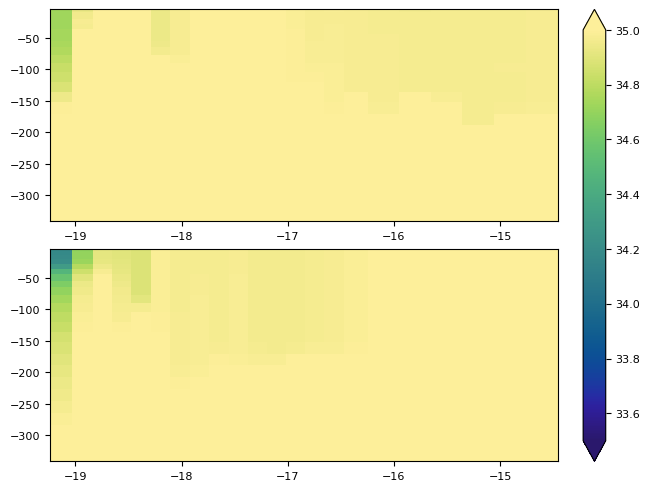

In [12]:
fig, (ax, ax2) = plt.subplots(2,1,layout='constrained')
X, Y = np.meshgrid([data.X.values for data in sec_obs[0]],sec_mod[0][0].Z.values)

cmap = cmo.haline

mesh = ax.pcolormesh(X,Y,np.array([data.SA.values for data in sec_obs[0]]).T, cmap=cmap, vmin=33.5, vmax=35)
ax2.pcolormesh(X,Y,np.array([data.SA.values for data in sec_mod[0]]).T, cmap=cmap, vmin=33.5, vmax=35)
cbar = fig.colorbar(mesh, ax=[ax,ax2], extend='both')

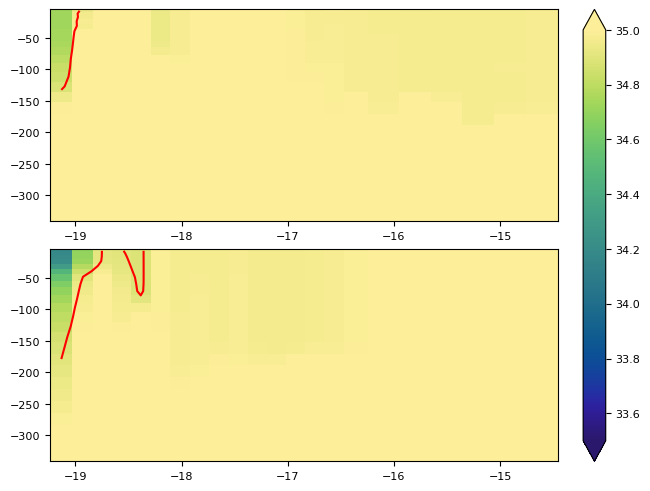

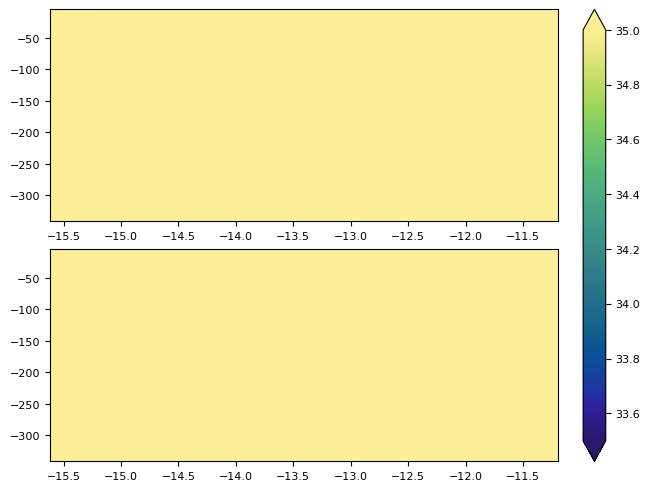

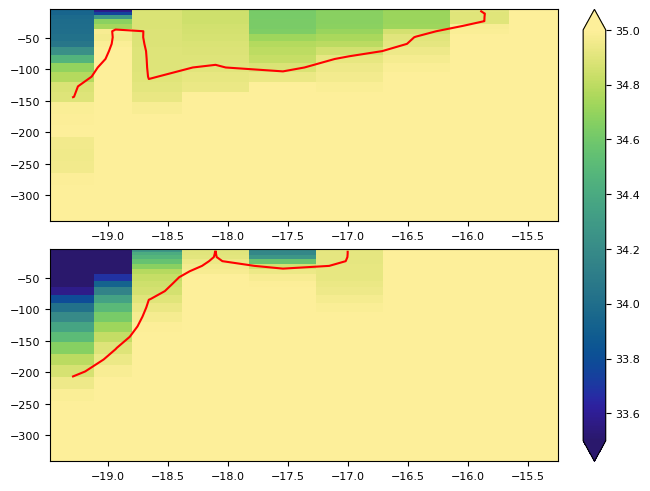

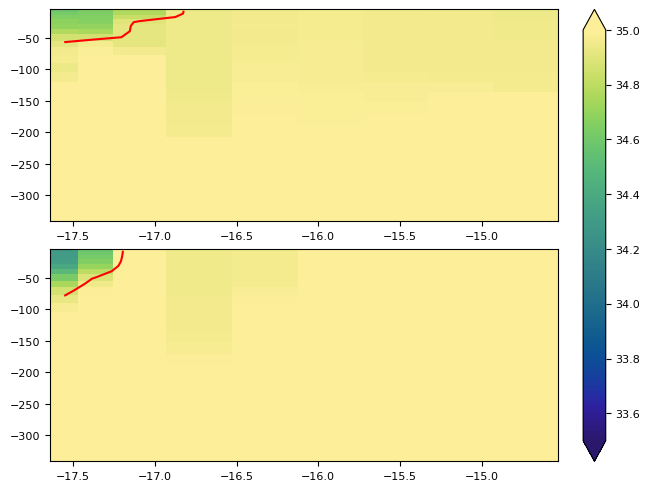

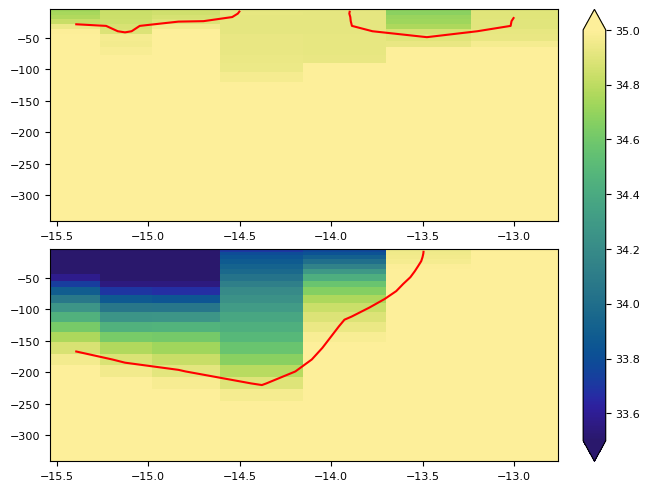

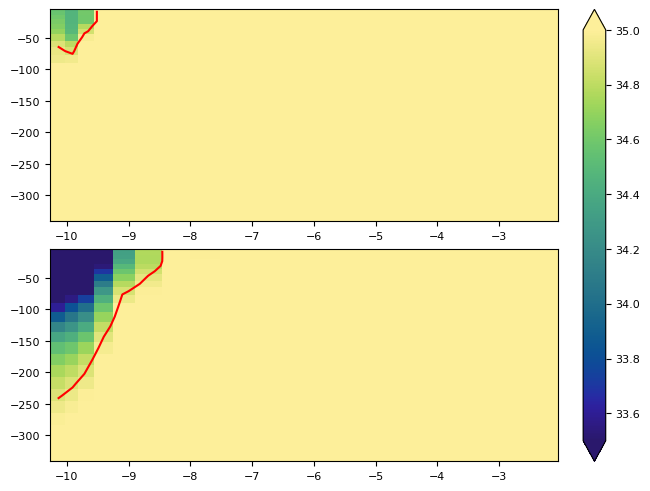

In [13]:
for i in range(0,6):
    fig, (ax, ax2) = plt.subplots(2,1,layout='constrained')
    X, Y = np.meshgrid([data.X.values for data in sec_obs[i]],sec_mod[i][0].Z.values)

    cmap = cmo.haline

    mesh = ax.pcolormesh(X,Y,np.array([data.SA.values for data in sec_obs[i]]).T, cmap=cmap, vmin=33.5, vmax=35)
    ax.contour(X,Y,np.array([data.SA.values for data in sec_obs[i]]).T,[34.9],colors='red')
    ax2.pcolormesh(X,Y,np.array([data.SA.values for data in sec_mod[i]]).T, cmap=cmap, vmin=33.5, vmax=35)
    ax2.contour(X,Y,np.array([data.SA.values for data in sec_mod[i]]).T,[34.9],colors='red')
    cbar = fig.colorbar(mesh, ax=[ax,ax2], extend='both')

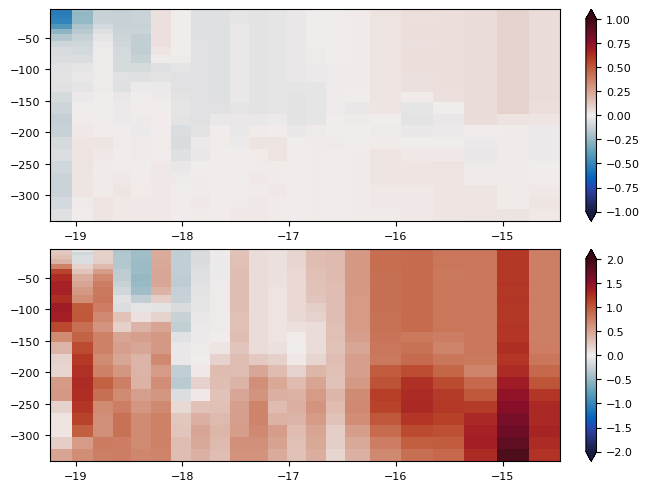

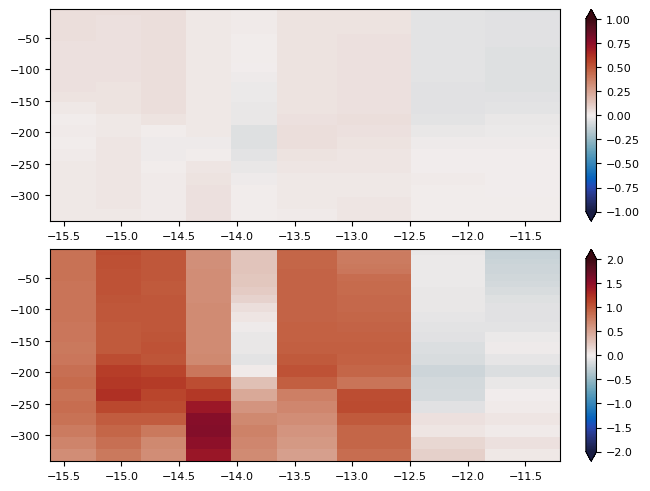

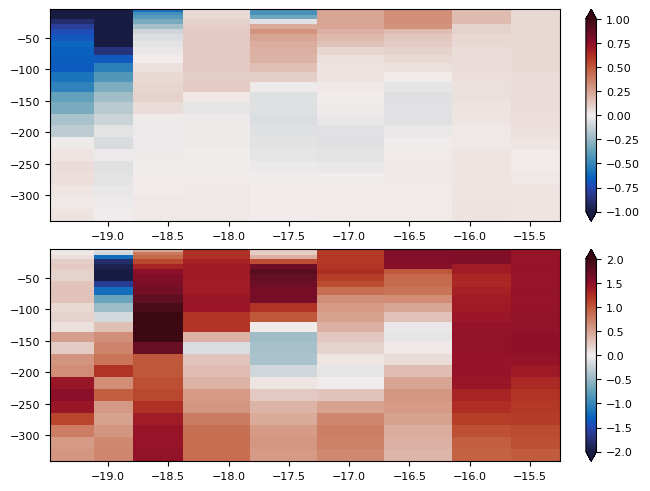

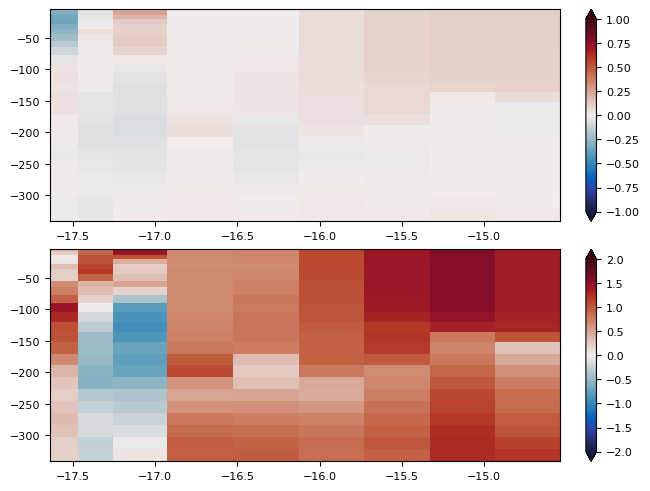

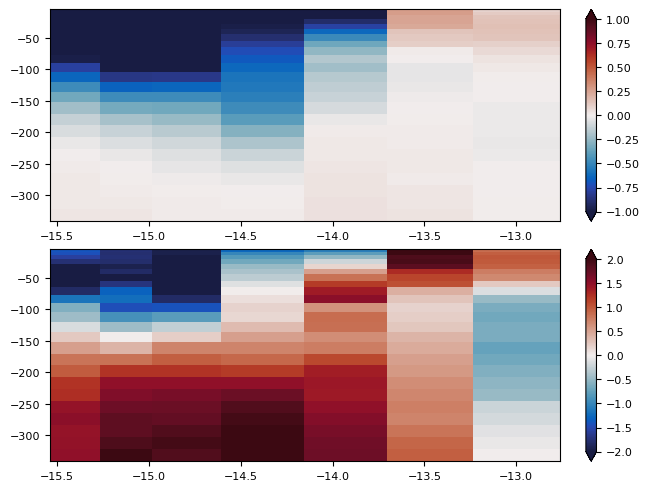

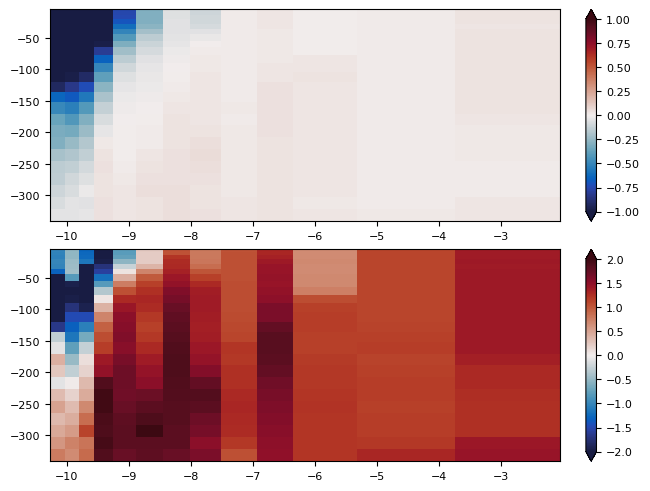

In [14]:
for i in range(0,6):
    fig, (ax, ax2) = plt.subplots(2,1,layout='constrained')
    X, Y = np.meshgrid([data.lon.values for data in anom_SA[i]],anom_SA[i][0].Z.values)

    cmap = cmo.balance

    mesh = ax.pcolormesh(X,Y,np.array([data.values for data in anom_SA[i]]).T, cmap=cmap, vmin=-1, vmax=1)
    cbar = fig.colorbar(mesh, ax=ax, extend='both')
    mesh = ax2.pcolormesh(X,Y,np.array([data.values for data in anom_CT[i]]).T, cmap=cmap, vmin=-2, vmax=2)
    cbar = fig.colorbar(mesh, ax=ax2, extend='both')
    

In [15]:
ref_S_data_mean_300 = []
ref_S_data_mean_all = []
temp_Z = []

for j, data in enumerate(anom_SA):
    for i, subdata in enumerate(data):
        for z in range(len(subdata.Z)):
            if len(temp_Z)<=len(subdata.Z)-1:
                temp_Z.append([anom_CT[j][i][z].values])
                ref_S_data_mean_all.append([anom_SA[j][i][z].values])
            else:
                temp_Z[z].append(anom_CT[j][i][z].values)
                ref_S_data_mean_all[z].append(anom_SA[j][i][z].values)

            # temp_Z.append(np.median(sec_var_T[j][i]))
            # ref_S_data_mean_300.append(np.mean(sec_var[j][i].sel(pressure=slice(200,700))))
            # ref_S_data_mean_all.append(np.median(sec_var[j][i]))

temp_median_Z = []
temp_mean_Z = []
S_median_Z = []
S_mean_Z = []

for i,j in zip(temp_Z,ref_S_data_mean_all):
    temp_median_Z.append(np.median(i))
    S_median_Z.append(np.median(j))
    temp_mean_Z.append(np.mean(i))
    S_mean_Z.append(np.mean(j))

median_all = np.mean(S_median_Z)
mean_all = np.mean(S_mean_Z)
# mean_anom_300 = np.mean(ref_S_data_mean_300)
temp_median = np.mean(temp_median_Z)
temp_mean = np.mean(temp_mean_Z)

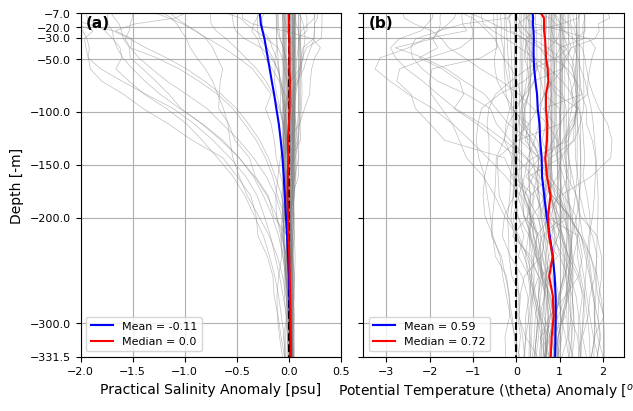

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6.2217, 4),layout='constrained',sharey=True)
#ax1.set_title('a) Model salinity anomaly from all observations',fontweight='bold',fontsize=12)

for data in anom_SA:
    for subdata in data:
        ax1.plot(subdata,subdata.Z,color='grey', linewidth=0.5,alpha=0.5)

ax1.plot([0 for x in anom_SA[0][0].Z],anom_SA[0][0].Z,color='black',linestyle='--')
ax1.plot(S_mean_Z,anom_SA[0][0].Z,color='blue',label=f'Mean = {np.round(mean_all,2)}')
ax1.plot(S_median_Z,anom_SA[0][0].Z,color='red',label=f'Median = {np.round(median_all,2)}')

ax1.set_xlim(-2,0.5)
ax1.set_ylim(anom_SA[0][0].Z[-1],anom_SA[0][0].Z[0])
ax1.set_yticks([anom_SA[0][0].Z[-1],-20,-30,-50,-100,-150,-200,-300,anom_SA[0][0].Z[0]])
ax1.set_ylabel('Depth [-m]')
ax1.set_xlabel('Practical Salinity Anomaly [psu]')
ax1.grid()
ax1.legend(loc='lower left')


#ax2.set_title('b) Model temperature anomaly from all observations',fontweight='bold',fontsize=12)
for data in anom_CT:
    for subdata in data:
        ax2.plot(subdata,subdata.Z,color='grey', linewidth=0.5,alpha=0.5)

ax2.plot([0 for x in anom_SA[0][0].Z],anom_SA[0][0].Z,color='black',linestyle='--')
ax2.plot(temp_mean_Z,anom_SA[0][0].Z,color='blue',label=f'Mean = {np.round(temp_mean,2)}')
ax2.plot(temp_median_Z,anom_SA[0][0].Z,color='red',label=f'Median = {np.round(temp_median,2)}')

ax2.set_ylim(anom_SA[0][0].Z[-1],anom_SA[0][0].Z[0])
ax2.set_yticks([anom_SA[0][0].Z[-1],-20,-30,-50,-100,-150,-200,-300,anom_SA[0][0].Z[0]])
# ax2.set_ylabel('Depth [-m]',fontsize=12)
ax2.set_xlabel(r'Potential Temperature (\theta) Anomaly [$^oC$]')
ax2.grid()
ax2.legend(loc='lower left')

ax1.annotate(text='(a)',xy=[-1.95,-20],fontweight='bold')
ax2.annotate(text='(b)',xy=[-3.4,-20],fontweight='bold')

fig.savefig(r'/nird/home/ekv036/MSc/Fig/modelBias',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

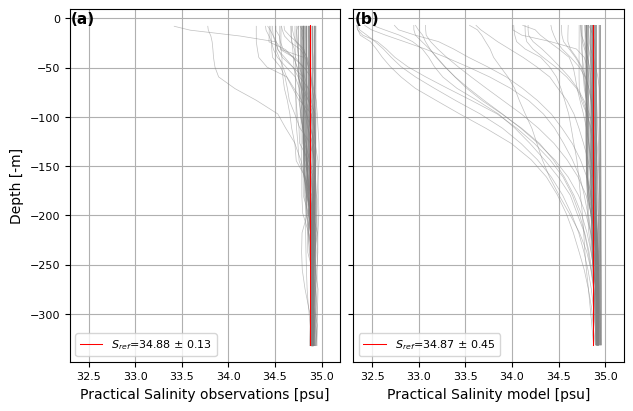

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6.2217, 4),layout='constrained',sharey=True)

ref_S_mod = []
ref_S_obs = []

for data in sec_obs:
    for subdata in data:
        ref_S_obs.append(gsw.SR_from_SP(subdata.S))
        ax1.plot(subdata.S,subdata.Z,color='grey', linewidth=0.5,alpha=0.5)

for data in sec_mod:
    for subdata in data:
        ref_S_mod.append(gsw.SR_from_SP(subdata.S))
        ax2.plot(subdata.S,subdata.Z,color='grey', linewidth=0.5,alpha=0.5)

ref_S_mod = [gsw.SP_from_SR(np.median(ref_S_mod)),np.std(ref_S_mod)]
ref_S_obs = [gsw.SP_from_SR(np.median(ref_S_obs)),np.std(ref_S_obs)]

ax1.plot([ref_S_obs[0] for x in subdata.Z],subdata.Z, linewidth=0.75, color='red',label=f'$S_{{ref}}$={np.round(ref_S_obs[0],2)} $\pm$ {np.round(ref_S_obs[1],2)}')
ax2.plot([ref_S_mod[0] for x in subdata.Z],subdata.Z, linewidth=0.75, color='red',label=f'$S_{{ref}}$={np.round(ref_S_mod[0],2)} $\pm$ {np.round(ref_S_mod[1],2)}')

ax1.grid()
ax2.grid()
ax1.set_xlim(32.3,35.2)
ax2.set_xlim(32.3,35.2)

ax1.set_ylabel('Depth [-m]')

ax1.set_xlabel('Practical Salinity observations [psu]')
ax2.set_xlabel('Practical Salinity model [psu]')

ax1.annotate(text='(a)',xy=[32.31,-5],fontweight='bold')
ax2.annotate(text='(b)',xy=[32.31,-5],fontweight='bold')

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')

fig.savefig(r'/nird/home/ekv036/MSc/Fig/refS_profiles',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

In [18]:
print(gsw.SP_from_SR(34.66))

34.49733030305098


# Computing density from utils MITgcm

In [19]:
from MITgcm_mutils_density import unesco

obs_S = [] # Salinity
obs_T = [] # Temperature
obs_D = [] # Density
obs_Z = [] # Depth

mod_S = [] # Salinity
mod_T = [] # Temperature
mod_D = [] # Density
mod_Z = [] # Depth

for j in range(len(sec_mod)):
    for i in range(len(sec_mod[j])):
        density_obs = unesco(sec_obs[j][i].S,sec_obs[j][i].PT,sec_obs[j][i].p)
        density_mod = unesco(sec_mod[j][i].S,sec_mod[j][i].Temp,sec_mod[j][i].p)

        obs_S.append(sec_obs[j][i].S)
        obs_T.append(sec_obs[j][i].PT)
        obs_D.append(density_obs)
        obs_Z.append(sec_obs[j][i].Z)

        mod_S.append(sec_mod[j][i].S)
        mod_T.append(sec_mod[j][i].Temp)
        mod_D.append(density_mod)
        mod_Z.append(sec_mod[j][i].Z)



In [20]:
display(len(mod_D))

69

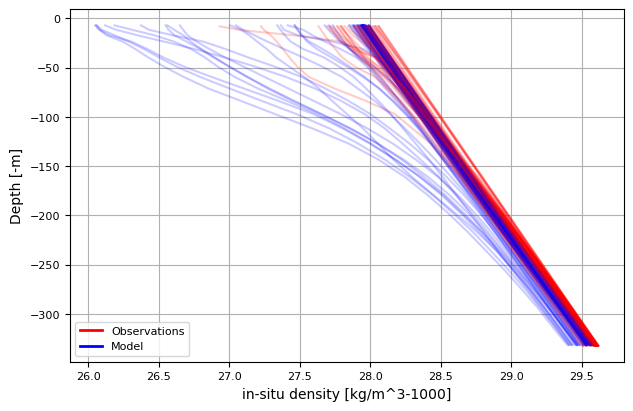

In [21]:
fig, ax1 = plt.subplots(figsize=(6.2217, 4),layout='constrained',sharey=True)

ref_S_mod = []
ref_S_obs = []

for j in range(len(sec_mod)):
    for i in range(len(sec_mod[j])):
        density_obs = unesco(sec_obs[j][i].S,sec_obs[j][i].PT,sec_obs[j][i].p)
        density_mod = unesco(sec_mod[j][i].S,sec_mod[j][i].Temp,sec_mod[j][i].p)

        ax1.plot(density_obs-1000,sec_obs[j][i].Z,color='red',alpha=0.2)
        ax1.plot(density_mod-1000,sec_mod[j][i].Z,color='blue',alpha=0.2)




ax1.grid()

ax1.set_ylabel('Depth [-m]')

ax1.set_xlabel('in-situ density [kg/m^3-1000]')

# Creating proxy artists
red_line = plt.Line2D([0], [0], color='r', lw=2)
blue_line = plt.Line2D([0], [0], color='b', lw=2)

# Adding the legend with proxy artists
ax1.legend([red_line, blue_line], ['Observations', 'Model'],loc='lower left')

fig.savefig(r'/nird/home/ekv036/MSc/Fig/density_prof',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

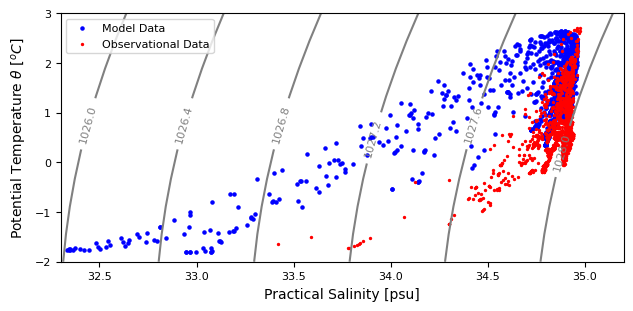

In [22]:
# T-S plot
T_lin = np.linspace(-2,3,10)
S_lin = np.linspace(32.3,35.2,10)

sigma = []

for x in S_lin:
    column = []
    for y in T_lin:
        column.append(unesco(x,y,0))
    sigma.append(column)


fig, ax = plt.subplots(figsize=(6.2217, 3),layout='constrained')
for data in sec_mod:
    for subdata in data:
        ax.scatter(subdata.S,subdata.Temp,s=5,color='blue',label='Model Data')

for data in sec_obs:
    for subdata in data:
        ax.scatter(subdata.S,subdata.PT,s=2,color='red',label='Observational Data')

cntr = ax.contour(S_lin,T_lin,np.array(sigma).transpose(),colors='grey')
ax.clabel(cntr,fmt="%2.1f",use_clabeltext=True, fontsize=8)

ax.set_xlim(32.3,35.2)
ax.set_ylim(-2,3)

ax.set_xlabel('Practical Salinity [psu]')
ax.set_ylabel(r'Potential Temperature $\theta$ [$^oC$]')

# Create custom legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

fig.savefig('/nird/home/ekv036/MSc/Fig/TS_plot',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

# Area anomaly map at depth

In [23]:
# FWC

vertical_res = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/drF.nc')['drF']

def FWC_fixed_structure(obs=False,model=False,data=list,ref_salinity=float,vertical_res_model=xr.Dataset):
    return_data = []
    obs_res = vertical_res_model
    if obs:
        for subdata in data:
            sec = []
            for subsubdata in subdata:
                pros = ((ref_salinity-subsubdata.S)/ref_salinity) * obs_res[0:len(subsubdata.S)].values
                pros2 = pros.cumsum()
                pros3 = pros2.max()
                sec.append(pros3)
            return_data.append(sec)

    elif model:
        for subdata in data:
            sec = []
            for subsubdata in subdata:
                pros = ((ref_salinity-subsubdata.S)/ref_salinity )* vertical_res_model[0:len(subsubdata.S)].values
                pros2 = pros.cumsum()
                pros3 = pros2.max()
                sec.append(pros3)
            return_data.append(sec)

    return return_data

FWC_obs = FWC_fixed_structure(obs=True,data=sec_obs,ref_salinity=34.81,vertical_res_model=vertical_res)
FWC_mod = FWC_fixed_structure(model=True,data=sec_mod,ref_salinity=34.81,vertical_res_model=vertical_res)

In [24]:
display(FWC_obs[0][0])

<xarray.DataArray 'S' ()>
array(0.57152025)
Coordinates:
    Y        float64 69.74
    X        float64 -19.13
    time     datetime64[ns] 2018-02-14T18:28:59.999997

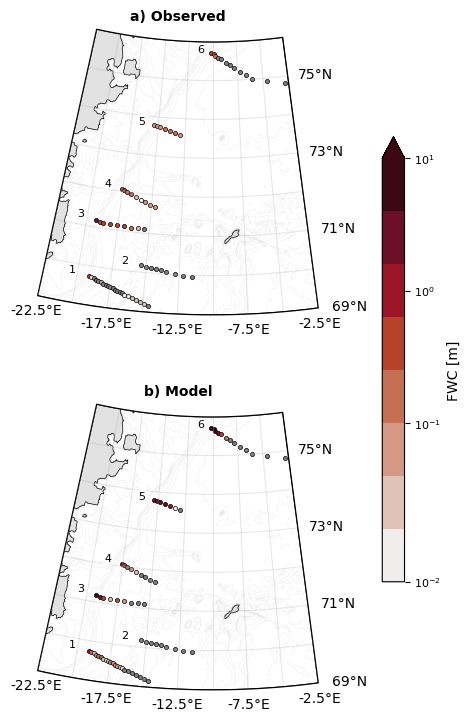

In [42]:
# Map of FWC with observations and model

depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(69,76)).sel(X=slice(-22.5,-2.5))
depth_notZero = depth
depth = depth.where(depth>=0,np.nan)

lon = depth['X']
lat = depth['Y']

fig, axs = plt.subplot_mosaic([['ul'], ['ll']],
                              # gridspec_kw={'width_ratios': [0.9, 0.1]},
                              subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-10)},
                              figsize=(4.6, 7.5), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-22.5+10, -2.5+10, 69, 76]

# # Plot the data using pcolormesh
# ax.pcolormesh(lon, lat, depth, cmap=cmo.deep,alpha=0.3, transform=ccrs.PlateCarree())
# Add land contour
land = depth_notZero.where(depth_notZero==0)

axs['ul'].pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100, transform=ccrs.PlateCarree())
axs['ll'].pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100, transform=ccrs.PlateCarree())

axs['ul'].contour(lon,lat,depth_notZero,[0], linewidths=0.5,colors='black', transform=ccrs.PlateCarree())
axs['ul'].contour(lon,lat,depth_notZero,[100,200,300,400,500,750,1000,1500,2000,3000,4000], linewidths=0.5,colors='grey',alpha=0.1, transform=ccrs.PlateCarree())
# # Plot the data using pcolormesh
# ax2.pcolormesh(lon, lat, depth, cmap=cmo.deep,alpha=0.3, transform=ccrs.PlateCarree())
# Add land contour
axs['ll'].contour(lon,lat,depth_notZero,[0], linewidths=0.5,colors='black', transform=ccrs.PlateCarree())
axs['ll'].contour(lon,lat,depth_notZero,[100,200,300,400,500,750,1000,1500,2000,3000,4000], linewidths=0.5,colors='grey',alpha=0.1, transform=ccrs.PlateCarree())

cmap = cmo.amp
norm = SymLogNorm(linthresh=0.015, vmin=0.01, vmax=10, base=10)

for sec, data in enumerate(zip(FWC_mod, FWC_obs)):
    for sta, sub in enumerate(zip(data[0], data[1])):
        # # Map the values to colors using SymLogNorm
        # color1 = cmap(norm(np.max(sub[0])))
        # color2 = cmap(norm(np.max(sub[1])))

        if sta == 0:
            axs['ul'].annotate(sec+1,(sub[0].lon-1.5, sub[0].lat),fontsize=8,transform=ccrs.PlateCarree(),bbox=dict(facecolor='white', alpha=1, edgecolor='none', boxstyle='round,pad=0.1'))
            axs['ll'].annotate(sec+1,(sub[0].lon-1.5, sub[0].lat),fontsize=8,transform=ccrs.PlateCarree(),bbox=dict(facecolor='white', alpha=1, edgecolor='none', boxstyle='round,pad=0.1'))
        
        if sub[0].values <= 0.005 or sub[1].values <= 0.005:
            if sub[0].values <= 0.005:
                axs['ll'].scatter(sub[0].lon, sub[0].lat, s=9, edgecolor='black', linewidths=0.5, c='grey', transform=ccrs.PlateCarree())
            else:
                axs['ll'].scatter(sub[0].lon, sub[0].lat, s=9, edgecolor='black', linewidths=0.5, c=sub[0], cmap=cmap.resampled(8), norm=norm, transform=ccrs.PlateCarree())
            
            if sub[1].values <= 0.005:
                axs['ul'].scatter(sub[1].X, sub[1].Y, s=9, edgecolor='black', linewidths=0.5, c='grey', transform=ccrs.PlateCarree())
            else:
                axs['ul'].scatter(sub[1].X, sub[1].Y, s=9, edgecolor='black', linewidths=0.5, c=sub[1], cmap=cmap.resampled(8), norm=norm, transform=ccrs.PlateCarree())
        else:
            axs['ul'].scatter(sub[1].X, sub[1].Y, s=9, edgecolor='black', linewidths=0.5, c=sub[1], cmap=cmap.resampled(8), norm=norm, transform=ccrs.PlateCarree())
            axs['ll'].scatter(sub[0].lon, sub[0].lat, s=9, edgecolor='black', linewidths=0.5, c=sub[0], cmap=cmap.resampled(8), norm=norm, transform=ccrs.PlateCarree())

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap.resampled(8)), shrink=0.6, pad=0.05,ax=[axs['ul'],axs['ll']],extend='max')
cbar.set_label('FWC [m]')

axs['ul'].set_title('a) Observed',fontweight='bold')
axs['ll'].set_title('b) Model',fontweight='bold')

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs['ul'].transData, edgecolor='black', facecolor='none')
axs['ul'].add_patch(patch)
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs['ll'].transData, edgecolor='black', facecolor='none')
axs['ll'].add_patch(patch)

# Set the boundary using the transformed path
axs['ul'].set_boundary(patch.get_path(), transform=axs['ul'].transData)
axs['ll'].set_boundary(patch.get_path(), transform=axs['ll'].transData)

# Add gridlines without labels
gl = axs['ul'].gridlines(draw_labels=False,alpha=0.3)
gl2 = axs['ll'].gridlines(draw_labels=False,alpha=0.3)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 5)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 2)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    axs['ul'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')
    axs['ll'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    axs['ul'].text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')
    axs['ll'].text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')

# Save the figure
fig.savefig('/nird/home/ekv036/MSc/Fig/FWC_obs_mod',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

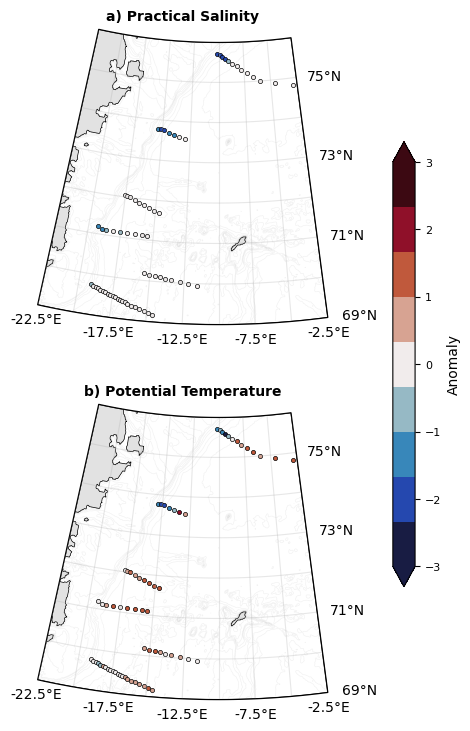

In [32]:
# Map of FWC with observations and model

depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(69,76)).sel(X=slice(-22.5,-2.5))
depth_notZero = depth
depth = depth.where(depth>=0,np.nan)

lon = depth['X']
lat = depth['Y']

fig, axs = plt.subplot_mosaic([['ul'], ['ll']],
                              # gridspec_kw={'width_ratios': [0.9, 0.1]},
                              subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-10)},
                              figsize=(4.6, 7.5), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-22.5+10, -2.5+10, 69, 76]

# # Plot the data using pcolormesh
# ax.pcolormesh(lon, lat, depth, cmap=cmo.deep,alpha=0.3, transform=ccrs.PlateCarree())
# Add land contour
land = depth_notZero.where(depth_notZero==0)

axs['ul'].pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100, transform=ccrs.PlateCarree())
axs['ll'].pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100, transform=ccrs.PlateCarree())

axs['ul'].contour(lon,lat,depth_notZero,[0], linewidths=0.5,colors='black', transform=ccrs.PlateCarree())
axs['ul'].contour(lon,lat,depth_notZero,[100,200,300,400,500,750,1000,1500,2000,3000,4000], linewidths=0.5,colors='grey',alpha=0.1, transform=ccrs.PlateCarree())
# # Plot the data using pcolormesh
# ax2.pcolormesh(lon, lat, depth, cmap=cmo.deep,alpha=0.3, transform=ccrs.PlateCarree())
# Add land contour
axs['ll'].contour(lon,lat,depth_notZero,[0], linewidths=0.5,colors='black', transform=ccrs.PlateCarree())
axs['ll'].contour(lon,lat,depth_notZero,[100,200,300,400,500,750,1000,1500,2000,3000,4000], linewidths=0.5,colors='grey',alpha=0.1, transform=ccrs.PlateCarree())

cmap = cmo.balance
norm = Normalize(vmin=-3,vmax=3)

for data in zip(sec_obs,sec_mod):
    for subdata in zip(data[0],data[1]):
        axs['ul'].scatter(subdata[0].X,subdata[0].Y,c=subdata[1].S.sel(Z=subdata[1].Z[1])-subdata[0].S.sel(Z=subdata[0].Z[1]),cmap=cmap.resampled(9),norm=norm, s=9,edgecolor='black', linewidths=0.5, transform=ccrs.PlateCarree())
        axs['ll'].scatter(subdata[0].X,subdata[0].Y,c=subdata[1].Temp.sel(Z=subdata[1].Z[1])-subdata[0].PT.sel(Z=subdata[0].Z[1]),cmap=cmap.resampled(9),norm=norm, s=9,edgecolor='black', linewidths=0.5, transform=ccrs.PlateCarree())

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap.resampled(9)), shrink=0.6, pad=0.05,ax=[axs['ul'],axs['ll']],extend='both')
cbar.set_label('Anomaly')

axs['ul'].set_title('a) Practical Salinity',fontweight='bold')
axs['ll'].set_title('b) Potential Temperature',fontweight='bold')

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs['ul'].transData, edgecolor='black', facecolor='none')
axs['ul'].add_patch(patch)
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs['ll'].transData, edgecolor='black', facecolor='none')
axs['ll'].add_patch(patch)

# Set the boundary using the transformed path
axs['ul'].set_boundary(patch.get_path(), transform=axs['ul'].transData)
axs['ll'].set_boundary(patch.get_path(), transform=axs['ll'].transData)

# Add gridlines without labels
gl = axs['ul'].gridlines(draw_labels=False,alpha=0.3)
gl2 = axs['ll'].gridlines(draw_labels=False,alpha=0.3)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 5)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 2)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    axs['ul'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')
    axs['ll'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    axs['ul'].text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')
    axs['ll'].text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')

# Save the figure
fig.savefig('/nird/home/ekv036/MSc/Fig/S_T_obs_mod',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)